In [2]:
# 모델 훈련
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_data) // batch_size,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/50
750/750 [==============================] - 236s 306ms/step - loss: 1.1669 - accuracy: 0.5010 - val_loss: 1.2549 - val_accuracy: 0.3803
Epoch 2/50
750/750 [==============================] - 239s 319ms/step - loss: 0.8953 - accuracy: 0.6156 - val_loss: 0.8917 - val_accuracy: 0.6125
Epoch 3/50
750/750 [==============================] - 232s 310ms/step - loss: 0.8319 - accuracy: 0.6456 - val_loss: 0.8733 - val_accuracy: 0.6165
Epoch 4/50
750/750 [==============================] - 226s 301ms/step - loss: 0.8025 - accuracy: 0.6585 - val_loss: 0.9216 - val_accuracy: 0.6090
Epoch 5/50
750/750 [==============================] - 225s 301ms/step - loss: 0.7716 - accuracy: 0.6727 - val_loss: 0.9419 - val_accuracy: 0.5926
Epoch 6/50
750/750 [==============================] - 221s 295ms/step - loss: 0.7575 - accuracy: 0.6796 - val_loss: 0.8378 - val_accuracy: 0.6481
Epoch 7/50
750/750 [==============================] - 225s 301ms/step - loss: 0.7443 - accuracy: 0.6857 - val_loss: 0.7895 -

In [3]:
model.save('D:\galaxy_classification\galaxy_classifier_ver13.h5')

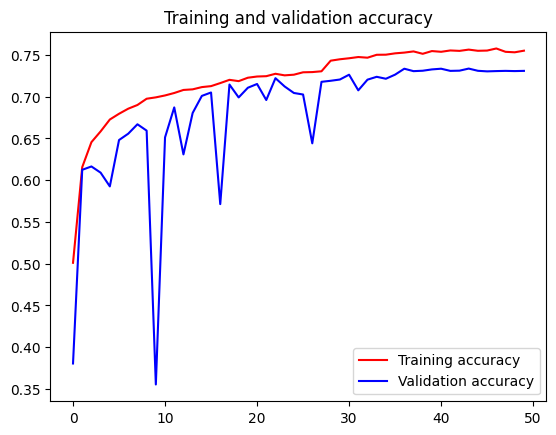

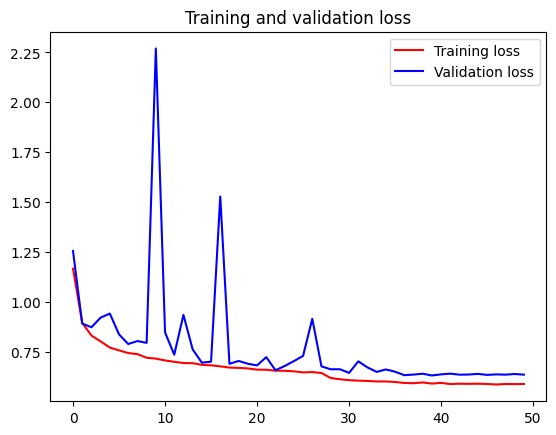

In [4]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

C:\Users\hyeonwoo\anaconda\envs\hw\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hyeonwoo\anaconda\envs\hw\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


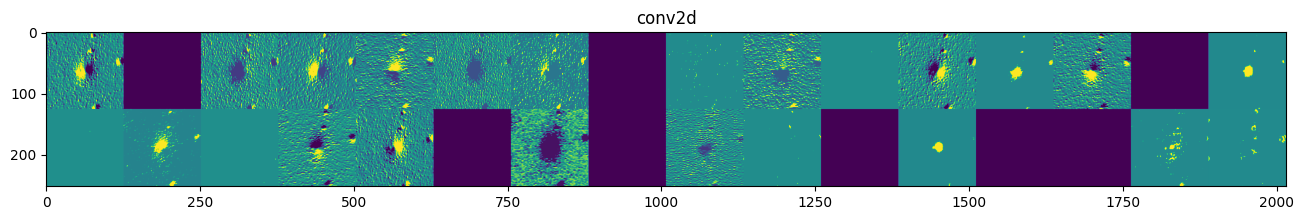

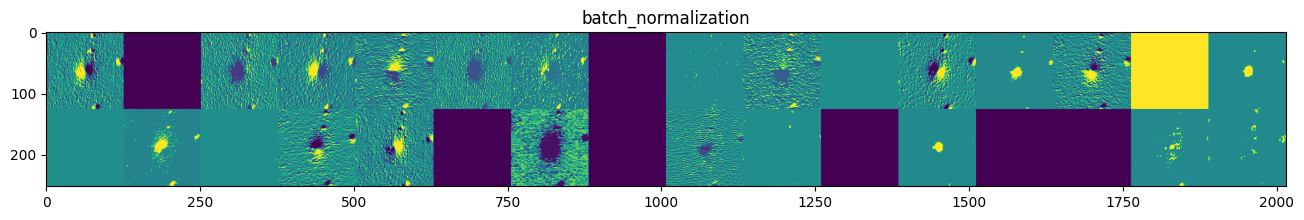

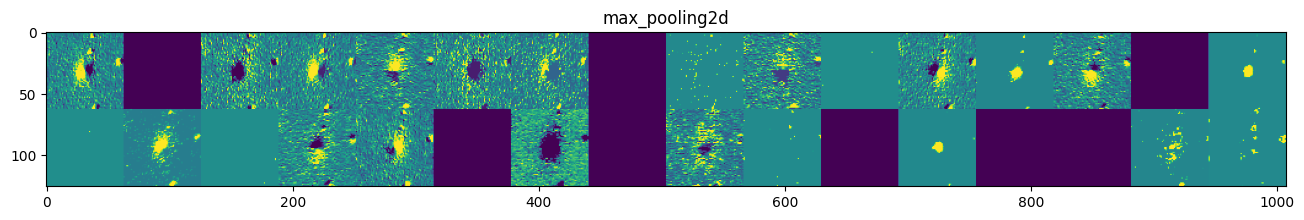

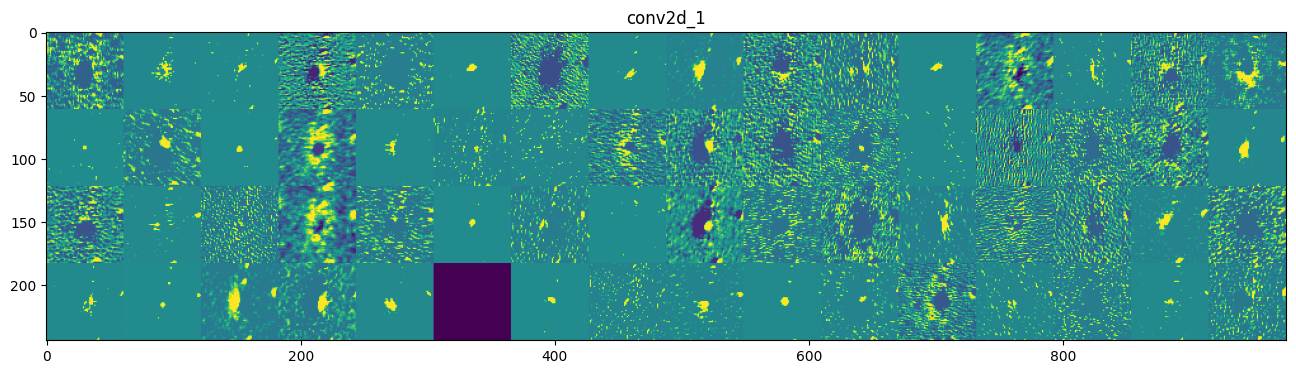

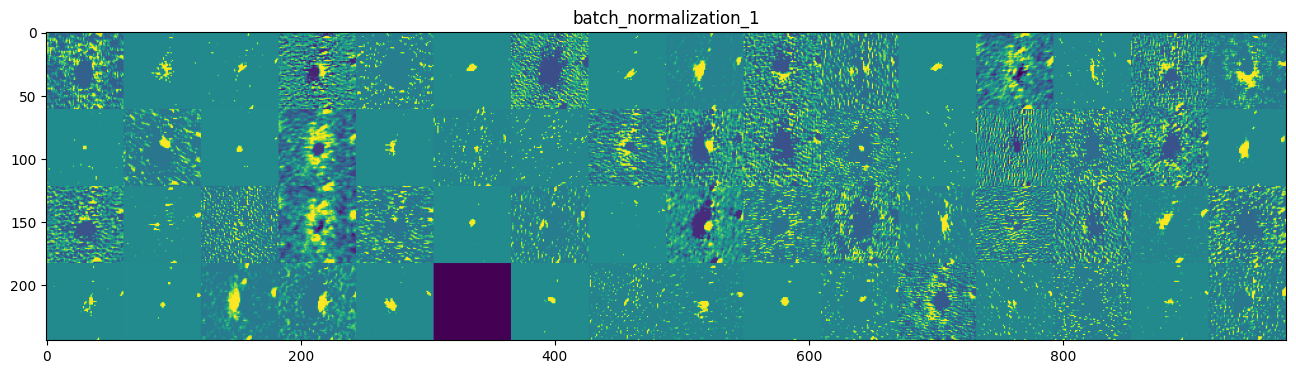

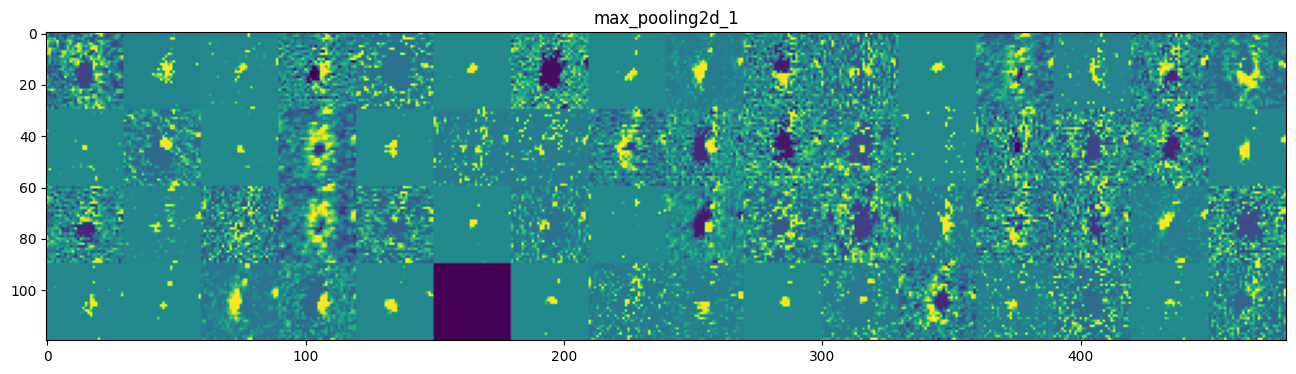

In [5]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

data_path = 'D:\galaxy_classification\data3.csv'
image_dir = 'D:\galaxy_classification\images'

data = pd.read_csv(data_path)

class_mapping = {'S': 0, 'E': 1, 'SB': 2, 'EDGE': 3}

model_path = 'D:\galaxy_classification\galaxy_classifier_ver13.h5'
model = load_model(model_path)

layer_outputs = [layer.output for layer in model.layers[:6]] 
activation_model = Model(inputs=model.input, outputs=layer_outputs)

image_id = data.iloc[0]['image_id'] 
img_path = os.path.join(image_dir, f"{image_id}.jpg")
img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

activations = activation_model.predict(img_array)

layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name) 

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] 
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row 
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

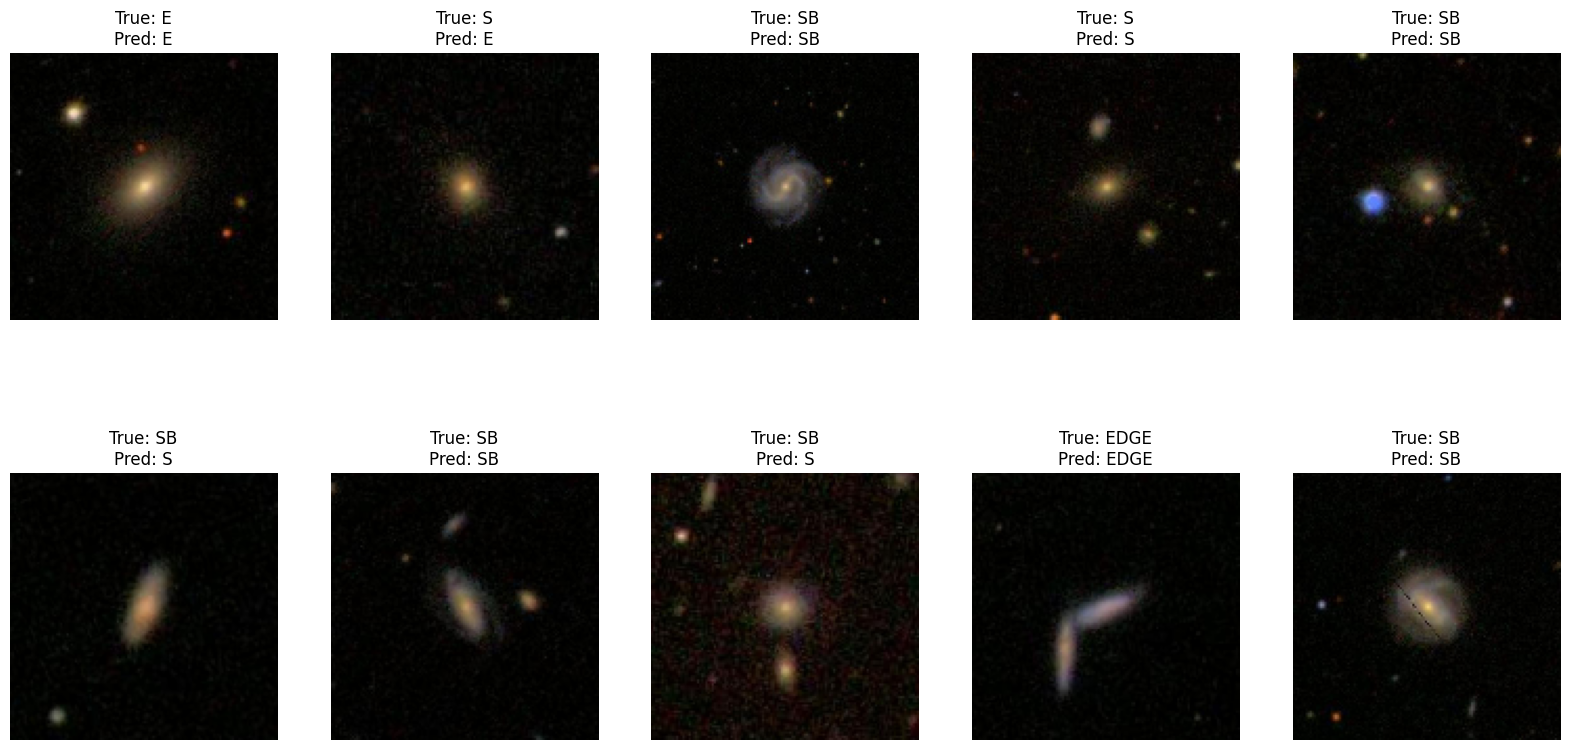

In [6]:
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

data_path = 'D:\galaxy_classification\data3.csv'
image_dir = 'D:\galaxy_classification\images'

data = pd.read_csv(data_path)

class_mapping = {'S': 0, 'E': 1, 'SB': 2, 'EDGE': 3}

from sklearn.model_selection import train_test_split
_, val_data = train_test_split(data, test_size=0.2, random_state=42)

model_path = 'D:\galaxy_classification\galaxy_classifier_ver13.h5'

model = load_model(model_path)

def compare_predictions(model, data, image_dir, class_mapping, num_samples=10):
    samples = data.sample(n=num_samples)
    plt.figure(figsize=(20, 10))

    for i, (_, row) in enumerate(samples.iterrows()):
        image_id = row['image_id']
        true_label = row['class']
        
        image_path = os.path.join(image_dir, f"{image_id}.jpg")
        
        if os.path.exists(image_path):
            img = load_img(image_path, target_size=(128, 128))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]
            
            inv_class_mapping = {v: k for k, v in class_mapping.items()}
            predicted_label = inv_class_mapping[predicted_class]
            
            plt.subplot(2, num_samples // 2, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {predicted_label}")
            plt.axis('off')

    plt.show()

compare_predictions(model, val_data, image_dir, class_mapping, num_samples=10)